In [1]:
from torchvision.models import detection
from torch import nn
import torch.nn.functional as F
import torch.onnx
import torch
import torchvision.transforms as tt
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt

## Initialize model

Define, load, and set to eval mode

In [2]:
class WhatBirdie(nn.Module):
    def __init__(self):
        super().__init__()

        #input: 3 x 224 x 224
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool4 = nn.MaxPool2d(4, 4)
        self.res1 = nn.Sequential(
            nn.Conv2d(6, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Conv2d(6, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU()
        )
        
        self.conv2 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.res2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.res3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.FConnected = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 700),
            nn.ReLU(),
            nn.Linear(700, 700),
            nn.ReLU(),
            nn.Linear(700, 325)
        )
        
        
    def forward(self, xb):
        #input: 3 x 224 x 224
        out = F.relu(self.bn1(self.conv1(xb)))   # output: 6 x 224 x224
        out = self.pool2(out)   # output: 6 x 112 x 112
        out = self.res1(out) + out   # output: 6 x 112 x 112
       
        out = F.relu(self.bn2(self.conv2(out)))   # output: 32 x 112 x 112
        out = self.pool2(out)    # output: 32 x 56 x 56
        out = self.res2(out) + out   # output: 32 x 56 x 56
       
        out = F.relu(self.bn3(self.conv3(out)))   # output: 64 x 56 x 56
        out = self.pool4(out)    # output: 64 x 14 x 14
        out = self.res3(out) + out    # output: 64 x 14 x 14
         
        out = F.relu(self.bn4(self.conv4(out)))   # output: 128 x 14 x 14
        out = self.pool2(out)    # output: 128 x 7 x 7

        out = self.FConnected(out)   

        return out
    
model = WhatBirdie()
model.load_state_dict(torch.load('../checkpoints/classification_checkpoint.pth', map_location='cpu'))
model.eval()

WhatBirdie(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (res1): Sequential(
    (0): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv2): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2):

## Input to the model

In [3]:
batch_size = 1
x = torch.randn(batch_size, 3, 224, 224)
torch_out = model(x)
torch_out.shape

torch.Size([1, 325])

## Export the model

In [4]:
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "bird_classification.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

## Verifying onnx model's structure & schema

In [5]:
import onnx

onnx_model = onnx.load("bird_classification.onnx")
onnx.checker.check_model(onnx_model)

In [6]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("bird_classification.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


Exported model has been tested with ONNXRuntime, and the result looks good!


# Testing on Image

Load image & note dimensions

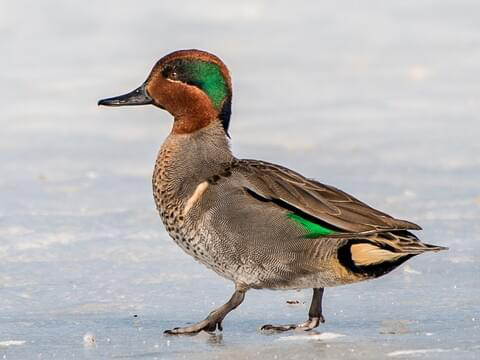

In [7]:
img = Image.open("../testimages/teal2.jpg")
height, width = img.size
img

### pad

In [8]:
maxsize = max(*img.size)
img_np = np.array(img)

In [9]:
pad_np = np.pad(img_np, ((int(height/10), int(height/10)), (int(width/10), int(width/10)), (0, 0)), mode='reflect')

(552, 456)


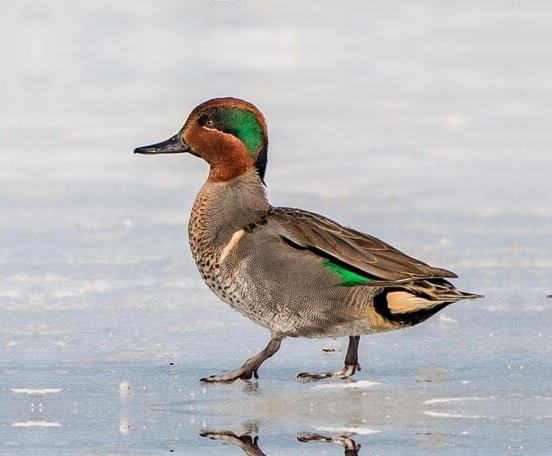

In [10]:
final_img = Image.fromarray(pad_np)
print(final_img.size)
final_img

### Centercrop

In [11]:
pad_np.shape

(456, 552, 3)

In [12]:
def crop_center(img, cropx, cropy):
        _, y, x = img.shape
        
        left = x // 2 - (maxsize // 2)
        right = x // 2 + (maxsize // 2)
        top = y // 2 - (maxsize // 2)
        bottom = y // 2 + (maxsize // 2)
        
#         startx = x // 2 - (cropx // 2)
#         starty = y // 2 - (cropy // 2)
        return img[:, top:bottom, left:right]

In [13]:
crop_np = crop_center(pad_np, maxsize, maxsize)

(480, 456), (456, 480, 3)


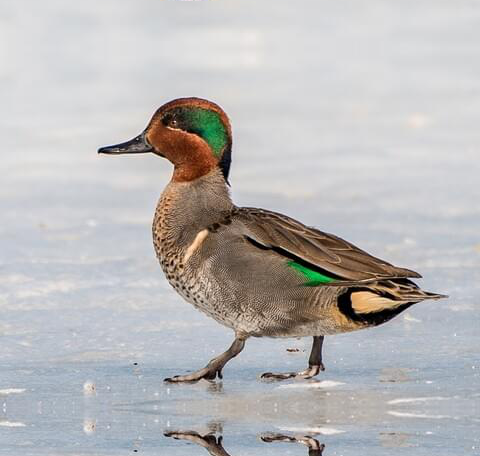

In [14]:
crop_img = Image.fromarray(crop_np)
print(f"{crop_img.size}, {crop_np.shape}")
crop_img

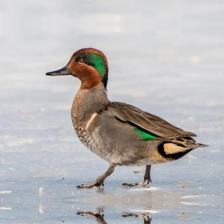

In [15]:
resize_img = crop_img.resize((224, 224), Image.BILINEAR) 
resize_img

## Normalize

In [16]:
nrml_img = np.array(resize_img).astype('float32')
nrml_img = np.transpose(nrml_img, [2, 0, 1])
nrml_img.shape

(3, 224, 224)

In [17]:
mean_vec = np.array([0.4914, 0.4822, 0.4465])
std_vec = np.array([0.2023, 0.1994, 0.2010])

for i in range(nrml_img.shape[0]):
    nrml_img[i, :, :] = (nrml_img[i, :, :] - mean_vec[i]) / (std_vec[i])

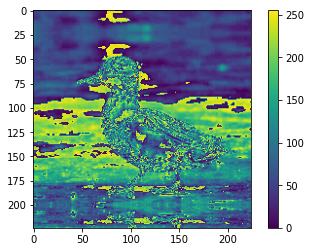

In [21]:
img = nrml_img[0, :, :].astype(np.uint8)
plt.imshow(img)
plt.colorbar()

In [ ]:
input_img = nrml_img
nrml_img.shape
torchinp = torch.tensor(nrml_img).unsqueeze(0)

In [ ]:
with torch.no_grad():
    torchpred = model.forward(torchinp)
torchpred.shape
plt.plot(torchpred[0])

# Predicting

### Creating a batch of single image

In [ ]:
input_batch = np.stack([input_img]*1)
input_batch.shape

### prediction

In [ ]:
model_onnx = 'bird_classification.onnx'

session = onnxruntime.InferenceSession(model_onnx, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [ ]:
input_batch[0].transpose(1,2,0)

In [ ]:
result = session.run([output_name], {input_name: input_batch})
prediction=int(np.argmax(np.array(result).squeeze(), axis=0))
print(prediction)

In [ ]:
result[0]

In [ ]:
import pandas as pd
species_list = pd.read_csv("../classes/species.csv")
species = species_list.iloc[prediction, 1]
print(species)